## Exploratory data analysis (EDA) of behvaioral data

###  Resolve subject IDs

Option 1: Using BIDS IDs by going over the BIDS tree

In [ ]:
import sys
sys.path.append("src")
import importlib
from src import resolve_ids
importlib.reload(sys.modules['src.resolve_ids'])
from src.resolve_ids import attach_bids_ids_to_behav

In [ ]:
BIDS_ROOT       = "/path/to/bids/dataset"
BEHAV_DATA_PATH = "/path/to/behavioral_data.csv"
OUTPUT_PATH     = "/path/to/output_with_bids_ids.csv"

In [ ]:
df = attach_bids_ids_to_behav(
    bids_root=BIDS_ROOT,
    behav_csv=BEHAV_DATA_PATH,
    output_csv=OUTPUT_PATH,
    csv_session_col="session_id",
)

Option 2: Using manifest file

In [ ]:
from src import resolve_ids
importlib.reload(sys.modules['src.resolve_ids'])
from src.resolve_ids import merge_behavior_with_manifest_by_session

In [ ]:
MANIFEST_TSV    = "/path/to/bids/dataset"
BEHAV_DATA_PATH = "/path/to/behavioral_data.csv"
OUTPUT_PATH     = "/path/to/output_with_bids_ids.csv"

In [ ]:
df = merge_behavior_with_manifest_by_session(
    manifest_tsv=MANIFEST_TSV,
    behavioral_csv=BEHAV_DATA_PATH,
    output_csv=OUTPUT_PATH
)

###  Analyze e-prime behavioral data

Loads e-prime txt files including subject ratings of political stimuli

In [ ]:
from pathlib import Path
import sys
sys.path.append("src")
from src.eprime_ratings import build_long_df

In [ ]:
# Loading all e-prime txt files and converting to long format csv of ratings (by subject code 00XX -
# TODO: integrate with bids subject code)

data_dir = Path("/path/to/behavioral_data_fmri")

df_ratings = build_long_df(
    data_dir,
    questionnaire_prefix="Potilical_views_questionnaire")

df_ratings.head()
out = data_dir / "political_views_ratings_long.csv"
df_ratings.to_csv(out, index=False)
out

In [ ]:
# calculate mean and SD for each question
import numpy as np

mean_q2 = np.mean(df_ratings["q2_support"])
sd_q2 = np.std(df_ratings["q2_support"])
mean_q5 = np.mean(df_ratings["q5_extreme"])
sd_q5 = np.std(df_ratings["q5_extreme"])
mean_q2, sd_q2, mean_q5, sd_q5

In [ ]:
# calculate Pearson correlation between q2_support and q5_extreme

from scipy.stats import pearsonr

r, p = pearsonr(df_ratings["q2_support"], df_ratings["q5_extreme"])
r, p


In [ ]:
# compare correlation among video type that include "Anti" vs "Pro"
df_anti = df_ratings[df_ratings["video_type"].str.contains("Anti")]
df_pro = df_ratings[df_ratings["video_type"].str.contains("Pro")]
r_anti, p_anti = pearsonr(df_anti["q2_support"], df_anti["q5_extreme"])
r_pro, p_pro = pearsonr(df_pro["q2_support"], df_pro["q5_extreme"])
r_anti, p_anti, r_pro, p_pro

In [ ]:
# compute correlation matrix for all questions
questions = ["q1_share", "q2_support", "q3_emotional", "q4_interesting", "q5_extreme"]
corr_matrix = df[questions].corr()
corr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Political Views Questions")
plt.show()

###  Analyze political attitude questionnaire

In [ ]:
from pathlib import Path
import sys
sys.path.append("src")
from behavioral_analyses.political_behavioral_analysis.src.political_attitude import load_political_attitudes_tsv, get_removed_rows_report

In [ ]:
clean = load_political_attitudes_tsv(
    "/path/to/behavioral_analyses/data/raw_data/political_attitude_q_08122025.tsv",
    save_csv="/path/to/behavioral_analyses/data/processed_data/political_attitude_q_08122025.csv")

removed = get_removed_rows_report(
    "/path/to/behavioral_analyses/data/raw_data/political_attitude_q_08122025.tsv")
removed["removed_progress_not_100"][[ "Q3", "Progress" ]]
len(clean), {k: len(v) for k, v in removed.items()}


### Correlate political attitudes with e-prime video ratings

In [ ]:
import pandas as pd

political_df = pd.read_csv("/path/to/behavioral_analyses/data/processed_data/political_attitude_q_08122025.csv")
fmri_df = pd.read_csv("/path/to/behavioral_data_fmri/political_views_ratings_long.csv")

political_df["subject_num"] = political_df["subject_num"].astype(int)
fmri_df["subject"] = fmri_df["subject"].astype(int)

merged = fmri_df.merge(
    political_df[["subject_num", "camp_support"]],
    left_on="subject",
    right_on="subject_num",
    how="inner"
)

from scipy.stats import spearmanr

results = []

for vt, subdf in merged.groupby("video_type"):
    r, p = spearmanr(
        subdf["camp_support"],
        subdf["q2_support"],
        nan_policy="omit"
    )
    results.append({
        "video_type": vt,
        "rho": r,
        "p": p,
        "n": subdf.shape[0]
    })

corr_df = pd.DataFrame(results)
corr_df

In [ ]:
# visualize the correlation results as line plot with data as points - make 4 panels one for each video type, y axis is q2_support and x axis is camp_support
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.lmplot(
    data=merged,
    x="camp_support",
    y="q2_support",
    col="video_type",
    height=4,
    aspect=1,
    scatter_kws={"s": 20, "alpha": 0.5},
    line_kws={"color": "red"}
)
plt.suptitle("Relationship between Camp Support and Q1 Support by Video Type", y=1.02)
plt.show()

### Analyzing political polarization questionnaire

In [ ]:
import sys
sys.path.append("src")
from political_polarization import load_qualtrics_tsv, compute_scores, write_codebook

df = load_qualtrics_tsv("/media/tzlil/FAB64374B6433085/Tzlil/behavioral_analyses/data/raw_data/political_polarization_q_08122025.tsv", subject_col="Code_tested", subject_prefix="YY_PL_")
print(df.shape)
print(df.head(3))

In [ ]:
# TODO: some scorings are not defined properly yet, need to fix in src/political_polarization.py

scored = compute_scores(df, center_policy="lean")
write_codebook("polarization_codebook.md")
scored.to_csv("/media/tzlil/FAB64374B6433085/Tzlil/behavioral_analyses/data/processed_data/political_polarization_scored.csv", index=False)


/tmp/ipykernel_1332896/1767704711.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


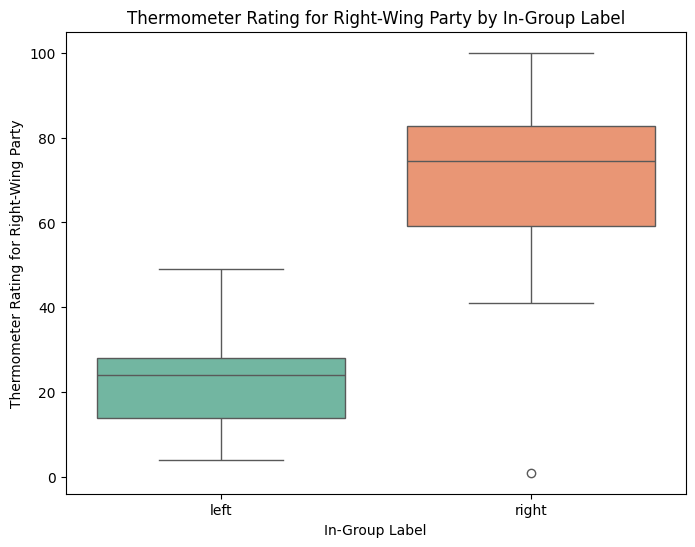

In [6]:
# create a box plot for thermo_right (y axis) by in_label (x axis)
import matplotlib.pyplot as plt
import seaborn as sns
scored.columns.tolist()[:20]  # optional quick check

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=scored,
    x="in_label",
    y="thermo_right",
    palette="Set2",
    showfliers=True)
plt.title("Thermometer Rating for Right-Wing Party by In-Group Label")
plt.xlabel("In-Group Label")
plt.ylabel("Thermometer Rating for Right-Wing Party")
plt.show()



/tmp/ipykernel_1332896/3420220477.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


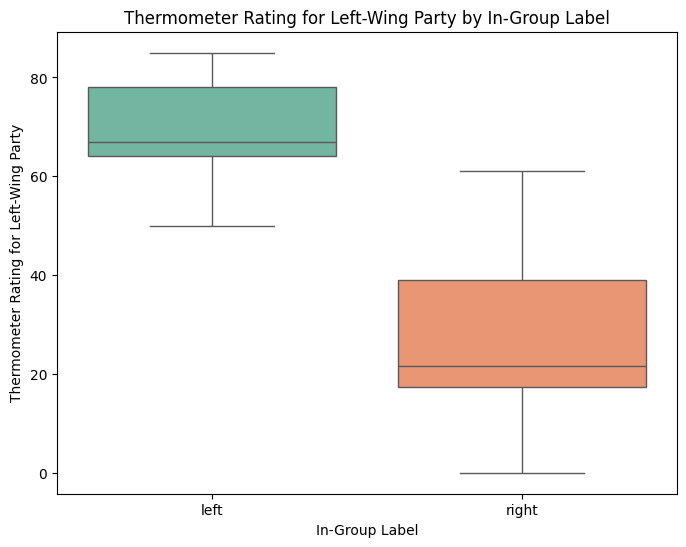

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=scored,
    x="in_label",
    y="thermo_left",
    palette="Set2",
    showfliers=True)
plt.title("Thermometer Rating for Left-Wing Party by In-Group Label")
plt.xlabel("In-Group Label")
plt.ylabel("Thermometer Rating for Left-Wing Party")
plt.show()